In [15]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics  import classification_report

Plot the accuracy vs the number of observations for our RNN.

In [30]:
survey = 'Gaia'
# survey='PanStarrs'

Load RNN results

In [ ]:
# Load the results for fold 1 for RNN
pred_rnn = pd.read_csv('../04_Compute_Metrics/'+survey+'/Results/Fold_1_Results.dat')
pred_rnn.index.name = 'ID'

# Load the metadata, to get the length.
if survey=='Gaia':
    path_metadata = './../../../../../Prepare_dataset/Gaia/V5/Dataset_Gaia_Phys_V5.dat'
    cols = ['N', 'N_b', 'N_r']
    path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/Gaia/Results/Pred_RBF_Gaia_Fold_1.dat'
elif survey=='PanStarrs':
    path_metadata = '../../../../../Prepare_dataset/PanStarrs/Dataset_PanStarrs_V2_ParamPhys.dat'
    cols =[ 'N','N_g', 'N_r', 'N_i', 'N_z', 'N_y']
    path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/PanStarrs/Results/Pred_RBF_PanStarrs_Fold_1.dat'
metadata = pd.read_csv(path_metadata)
metadata.set_index('ID', inplace=True)

df_rnn = pd.merge(pred_rnn[['Class', 'Pred']], metadata[cols], on='ID', how='inner')

Load RF rcolumnslts

In [ ]:
   
pred_rf = pd.read_csv(path_rf)
pred_rf.rename({'oid':'ID'}, axis=1, inplace=True)
pred_rf.set_index('ID', inplace=True)
df_rf = pd.merge(pred_rf[['Class', 'Pred']], metadata[cols], on='ID', how='inner')

In [ ]:
# Set the interval each 10 
if survey=='Gaia':
    interval = 10
    delta = interval/2
    N_max = np.ceil(df_rnn.N.max()/interval)
    XX = np.arange(25, N_max*interval, interval)
if survey=='PanStarrs':
    interval = 10
    delta = interval/2
    N_max = np.ceil(df_rnn.N.max()/interval)
    XX = np.arange(25, N_max*interval, interval)

In [ ]:
ACC_rnn = []
ACC_rf = []

N = []
deltas = []
for i in range(len(XX)):
    x = XX[i]
    deltas.append(delta)
    # Define the intervals
    below = x-delta
    above = x+delta
    # Create the bined dataframe for each model type
    b1 = df_rnn.N>=below
    b2 = df_rnn.N<above
    b = np.logical_and(b1, b2)
    sel_rnn = df_rnn[['Class', 'Pred', 'N']][b]
    
    # Create the bined dataframe for each model type
    b1 = df_rf.N>=below
    b2 = df_rf.N<above
    b = np.logical_and(b1, b2)
    sel_rf = df_rf[['Class', 'Pred', 'N']][b]
    

    
    # Compute the accuracy
    acc_rnn = np.sum(sel_rnn['Pred']==sel_rnn['Class'])/sel_rnn.shape[0]

    
    acc_rf= np.sum(sel_rf['Pred']==sel_rf['Class'])/sel_rf.shape[0]

    ACC_rnn.append(acc_rnn)        
    ACC_rf.append(acc_rf)        
    
    N.append(sel_rnn.shape[0])

In [ ]:
# Some bins have a vero low count. Merge bins of the boundaries.

new_XX = list(XX).copy()
new_N = N.copy()
new_deltas = deltas.copy()

cond_for = False
N_min = 10
condition_while=True
new_start = 0


temp_cont = 0
while condition_while:
    cond_for = False
    # print('\n iteration ', temp_cont)
    # print(new_start, len(new_N))
    # print(new_N)
    for i in range(new_start, len(new_N)):
        N_temp = new_N[i]
        X_temp = new_XX[i]
        d_temp = new_deltas[i]

        if N_temp<N_min and i<len(new_N)-1:
            # print('detected')
            # print(i, new_XX[i],N_temp)
            # Create the new bin
            X_temp = (new_XX[i]+new_XX[i+1])/2
            d_temp = new_deltas[i]+deltas[i+1]
            N_temp = new_N[i]+new_N[i+1]

            # Remove the last one
            new_XX.pop(i+1)
            new_deltas.pop(i+1)
            new_N.pop(i+1)

            # Replace the new values
            new_XX[i] = X_temp
            new_deltas[i] = d_temp
            new_N[i] = N_temp

            # Break the for loop and start again
            cond_for = True
            
        elif N_temp<N_min and i==len(new_N)-1:
            # print('detected end')
            # print(i, new_XX[i],N_temp)     

            # Create the new bin
            X_temp = (new_XX[i-1]+new_XX[i])/2
            d_temp = new_deltas[i-1]+deltas[i]
            N_temp = new_N[i-1]+new_N[i]            
          
            # Remove the last one
            new_XX.pop(i)
            new_deltas.pop(i)
            new_N.pop(i)
          
            # Replace the new values
            new_XX[i-1] = X_temp
            new_deltas[i-1] = d_temp
            new_N[i-1] = N_temp
            
            condition_while=False   
                
        # If found a bin, break
        if cond_for:
            # new_start = i
            break    

    temp_cont+=1
    if temp_cont>20:
        break  

        
ACC_rnn = []
ACC_rf = []
REP_rnn = []
REP_rf = []
for i in range(len(new_XX)):
    # print(i)
    # Define the intervals
    below = new_XX[i]-new_deltas[i]
    above = new_XX[i]+new_deltas[i]
    # Create the bined dataframe for each model type
    b1 = df_rnn.N>=below
    b2 = df_rnn.N<above
    b = np.logical_and(b1, b2)
    sel_rnn = df_rnn[['Class', 'Pred', 'N']][b]
    
    # Create the bined dataframe for each model type
    b1 = df_rf.N>=below
    b2 = df_rf.N<above
    b = np.logical_and(b1, b2)
    sel_rf = df_rf[['Class', 'Pred', 'N']][b]
    
    # Compute the accuracy
    acc_rnn = np.sum(sel_rnn['Pred']==sel_rnn['Class'])/sel_rnn.shape[0]
    acc_rf= np.sum(sel_rf['Pred']==sel_rf['Class'])/sel_rf.shape[0]
    # Compute the reports
    rep_RNN = classification_report(sel_rnn['Class'],sel_rnn['Pred'], output_dict=True, zero_division=0)
    rep_RF = classification_report(sel_rf['Class'],sel_rf['Pred'], output_dict=True, zero_division=0)
    # Aggregate results
    ACC_rnn.append(acc_rnn)        
    ACC_rf.append(acc_rf)        
    
    REP_rnn.append(rep_RNN)
    REP_rf.append(rep_RF)


[]

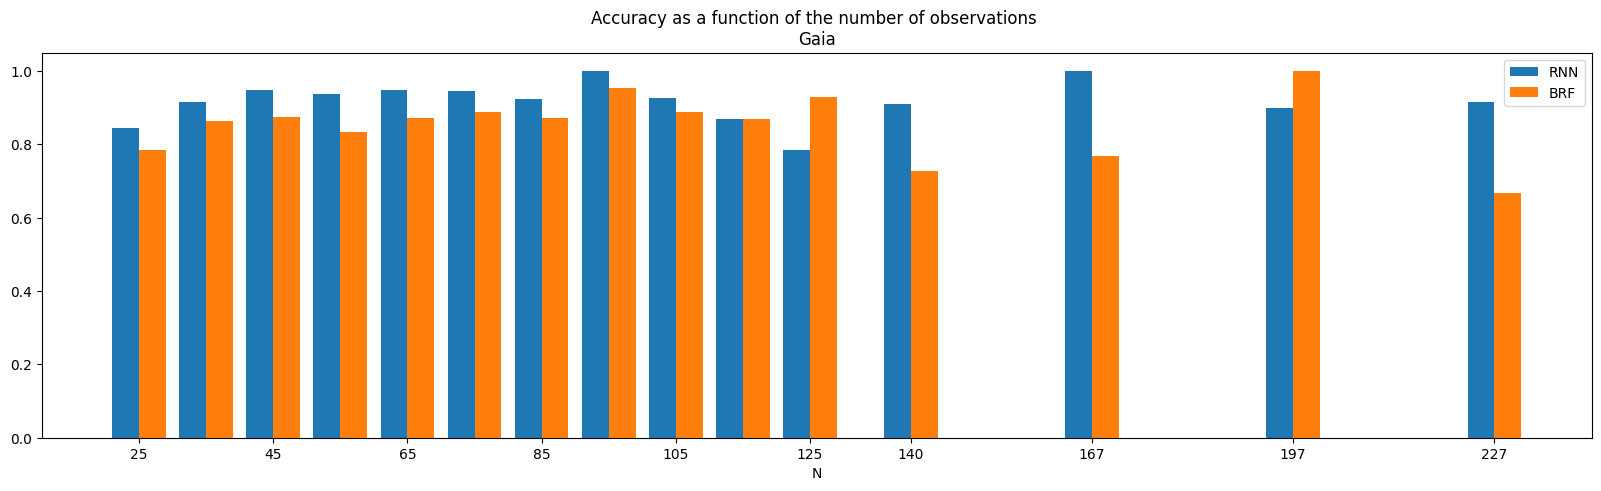

In [ ]:
    
new_XX = np.array(new_XX).astype(int)
new_deltas = np.array(new_deltas)    

# Custom ticks for Gauia
if survey=='Gaia':
    xticks = [i for i in range(new_XX.shape[0])  if new_XX[i]>125 or i%2==0  ]
elif survey=='PanStarrs':
    xticks = [i for i in range(new_XX.shape[0])]

plt.figure(figsize=(20,5))
plt.bar(new_XX-2, ACC_rnn, width=interval-6, label='RNN')
plt.bar(new_XX+2, ACC_rf, width=interval-6, label='BRF')
plt.xlabel('N')
plt.legend(loc=0)
plt.xticks(new_XX[xticks])
plt.title('Accuracy as a function of the number of observations \n'+survey)
plt.plot()

In [ ]:
# f1_rnn = [REP_rnn[i]['weighted avg']['f1-score'] for i in range(len(REP_rnn))]
# f1_rf = [REP_rf[i]['weighted avg']['f1-score'] for i in range(len(REP_rf))]

[]

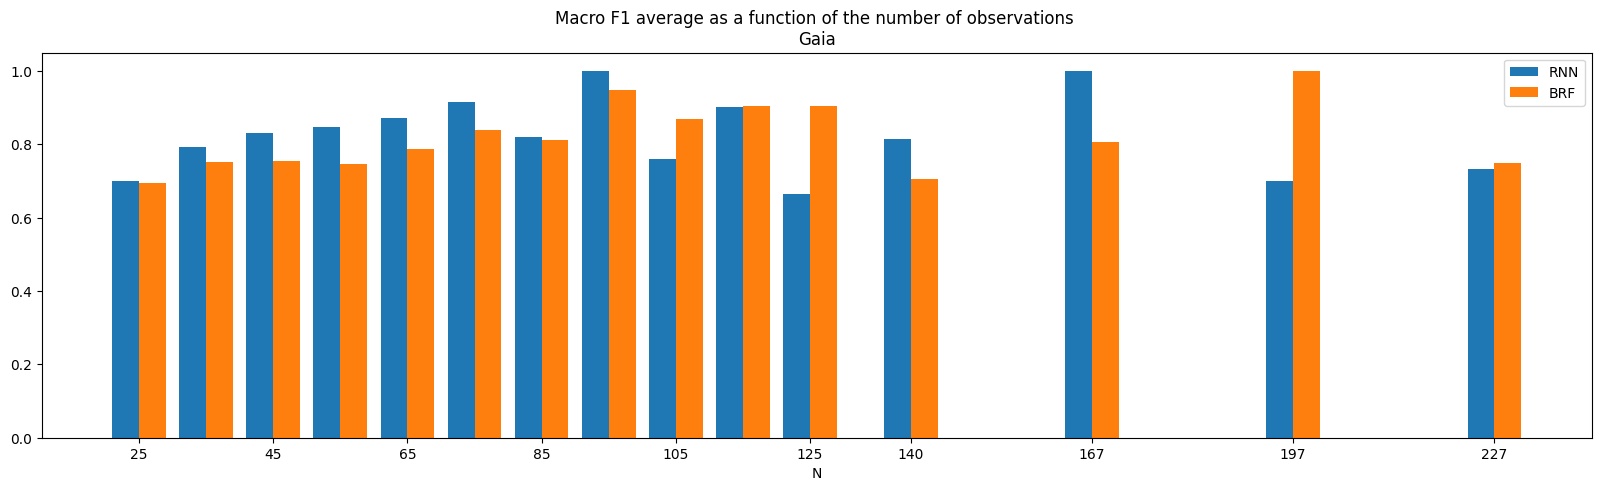

In [29]:
f1_rnn = [REP_rnn[i]['macro avg']['f1-score'] for i in range(len(REP_rnn))]
f1_rf = [REP_rf[i]['macro avg']['f1-score'] for i in range(len(REP_rf))]

plt.figure(figsize=(20,5))
plt.bar(new_XX-2, f1_rnn, width=interval-6, label='RNN')
plt.bar(new_XX+2, f1_rf, width=interval-6, label='BRF')
plt.xlabel('N')
plt.legend(loc=0)
plt.xticks(new_XX[xticks])
plt.title('Macro F1 average as a function of the number of observations \n'+survey)
plt.plot()